In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import mannwhitneyu, ttest_ind
from statannotations.Annotator import Annotator

In [2]:
# input files/dir
ANNOTATED_MUTATIONS = "../data/annotated_snv_mv_indels_by_cancer_subtype"
GENOME_WIDE_MUTATIONS = "../data/genome_wide_mutation_data.tsv"
DRIVER_GENES = "../data/driver_genes"

# output files/dir
MUTATION_BED = "../data/mutations_bed"
PROMOTERS_BED = "../data/promoters_bed"
MUTATIONS_IN_PROMOTERS = "../data/mutations_in_promoters"
MUTATION_DENSITY_FRACTION_RESULTS = "../results/mutation_density_fractions"
MUTATION_DENSITY_GENIC_REGIONS = "../results/mutation_density_genic_regions"
CADD_SCORES_ENRICHMENT = "../results/cadd_score_enrichment"
CADD_SCORES_GENIC_REGION = "../results/cadd_scores_genic_regions"

if not os.path.exists(MUTATION_BED):
    os.makedirs(MUTATION_BED)

if not os.path.exists(PROMOTERS_BED):
    os.makedirs(PROMOTERS_BED)

if not os.path.exists(MUTATIONS_IN_PROMOTERS):
    os.makedirs(MUTATIONS_IN_PROMOTERS)

if not os.path.exists(MUTATION_DENSITY_FRACTION_RESULTS):
    os.makedirs(MUTATION_DENSITY_FRACTION_RESULTS)
    
if not os.path.exists(MUTATION_DENSITY_GENIC_REGIONS):
    os.makedirs(MUTATION_DENSITY_GENIC_REGIONS)
    
if not os.path.exists(CADD_SCORES_ENRICHMENT):
    os.makedirs(CADD_SCORES_ENRICHMENT)
    
if not os.path.exists(CADD_SCORES_GENIC_REGION):
    os.makedirs(CADD_SCORES_GENIC_REGION)

CANCER_TYPES = os.listdir(DRIVER_GENES) # cancer types that have driver gene data
CANCER_TYPES = [cancer_type for cancer_type in CANCER_TYPES if cancer_type.endswith(".tsv")]
CANCER_TYPES = [cancer_type.replace(".tsv", "") for cancer_type in CANCER_TYPES]
print(len(CANCER_TYPES), CANCER_TYPES)

31 ['CNS-Oligo', 'Kidney-ChRCC', 'Prost-AdenoCA', 'Kidney-RCC', 'Stomach-AdenoCA', 'CNS-Medullo', 'Thy-AdenoCA', 'Myeloid-MPN', 'Bone-Leiomyo', 'Lymph-BNHL', 'Myeloid-AML', 'Lung-AdenoCA', 'CNS-GBM', 'Head-SCC', 'Breast-AdenoCa', 'Ovary-AdenoCA', 'CNS-PiloAstro', 'Cervix-SCC', 'Liver-HCC', 'Bone-Osteosarc', 'Biliary-AdenoCA', 'Skin-Melanoma', 'Lung-SCC', 'Lymph-CLL', 'Panc-Endocrine', 'Bladder-TCC', 'Panc-AdenoCA', 'ColoRect-AdenoCA', 'Breast-LobularCa', 'Eso-AdenoCa', 'Uterus-AdenoCA']


In [3]:
# all mutations in tumor samples for all cancer types
all_cancer_tumor_list = {}
tumor_mut_df = pd.DataFrame()
for cancer_type in CANCER_TYPES:
	tumor_mut_cancer_df = pd.read_csv(f"{ANNOTATED_MUTATIONS}/{cancer_type}.tsv", sep="\t")
	all_cancer_tumor_list[cancer_type] = tumor_mut_cancer_df["Tumor_Sample_Barcode"].unique().tolist()

	tumor_mut_cancer_df["cancer_type"] = cancer_type
	tumor_mut_cancer_df["mutation_loc"] = tumor_mut_cancer_df["mutation"].apply(lambda x: ":".join(x.split(":")[:2]))
	print(cancer_type, len(tumor_mut_cancer_df))

	# get driver genes for the cancer type
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	driver_genes_list = driver_genes["gene"].tolist()
	driver_genes["promoter_length"] = driver_genes["promoter_end"] - driver_genes["promoter_start"] + 1
	driver_genes = driver_genes[["gene", "gene_length", "promoter_length"]]
	tumor_mut_cancer_df = tumor_mut_cancer_df[tumor_mut_cancer_df['gene'].isin(driver_genes_list)]
	tumor_mut_cancer_df = tumor_mut_cancer_df.merge(driver_genes, on="gene", how="left")
	print(cancer_type, len(tumor_mut_cancer_df))

	tumor_mut_df = pd.concat([tumor_mut_df, tumor_mut_cancer_df], axis=0)

# get genome wide mutations for the cancer type
genome_wide_mutation_density_cancer = pd.read_csv(GENOME_WIDE_MUTATIONS, sep="\t")
genome_wide_mutation_density_cancer.rename(columns={"total_mutations": "genome_wide_mutation_rate"}, inplace=True)
tumor_mut_df = tumor_mut_df.merge(genome_wide_mutation_density_cancer[["Tumor_Sample_Barcode", "genome_wide_mutation_rate", "cna_burden"]], on="Tumor_Sample_Barcode", how="left")
    
print(tumor_mut_df.shape)
tumor_mut_df.head()

CNS-Oligo 52437
CNS-Oligo 54
Kidney-ChRCC 129072
Kidney-ChRCC 34
Prost-AdenoCA 1151290
Prost-AdenoCA 3437
Kidney-RCC 1039854
Kidney-RCC 1861
Stomach-AdenoCA 2444583
Stomach-AdenoCA 5903
CNS-Medullo 235074
CNS-Medullo 189
Thy-AdenoCA 69387
Thy-AdenoCA 37
Myeloid-MPN 60123
Myeloid-MPN 27
Bone-Leiomyo 193289
Bone-Leiomyo 88
Lymph-BNHL 1340921
Lymph-BNHL 3049
Myeloid-AML 23027
Myeloid-AML 16
Lung-AdenoCA 1415582
Lung-AdenoCA 462
CNS-GBM 546004
CNS-GBM 436
Head-SCC 950040
Head-SCC 3459
Breast-AdenoCa 1510556
Breast-AdenoCa 2104
Ovary-AdenoCA 1085069
Ovary-AdenoCA 896
CNS-PiloAstro 23106
CNS-PiloAstro 64
Cervix-SCC 121082
Cervix-SCC 18
Liver-HCC 4221198
Liver-HCC 6275
Bone-Osteosarc 175911
Bone-Osteosarc 226
Biliary-AdenoCA 599377
Biliary-AdenoCA 331
Skin-Melanoma 12450635
Skin-Melanoma 25121
Lung-SCC 2234456
Lung-SCC 5319
Lymph-CLL 239363
Lymph-CLL 135
Panc-Endocrine 272067
Panc-Endocrine 177
Bladder-TCC 523968
Bladder-TCC 534
Panc-AdenoCA 1916236
Panc-AdenoCA 5081
ColoRect-AdenoCA 11262335

,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,cancer_type,gene_length,promoter_length,genome_wide_mutation_rate,cna_burden
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869-78425869,True,"mutational, CNA",True,exonic,6.224800,33.000,CNS-Oligo,35055,2501,2778,17.32418
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826-42791826,True,"mutational, CNA",True,exonic,5.575207,29.700,CNS-Oligo,27261,2501,2778,17.32418
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878-42798878,True,"mutational, CNA",True,exonic,4.657281,25.400,CNS-Oligo,27261,2501,2778,17.32418
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112-209113112,True,mutational,True,exonic,3.897263,23.400,CNS-Oligo,29848,2501,2778,17.32418
4,TERT,+,5'Flank,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,5:1295228-1295228:G:A,5:1295228-1295228,True,mutational,True,upstream,0.389117,6.721,CNS-Oligo,41923,2501,2778,17.32418


In [4]:
all_tumor_mut_promoter = pd.DataFrame()

for cancer_type in CANCER_TYPES:
	driver_genes = os.path.join(DRIVER_GENES, cancer_type + ".tsv")
	if not os.path.exists(driver_genes):
		continue
		
	# get bed file of mutations
	tumor_mut_cancer_df = tumor_mut_df[tumor_mut_df["cancer_type"] == cancer_type]
	print("Mutations:", cancer_type, tumor_mut_cancer_df.shape)
	tumor_mut_bed = tumor_mut_cancer_df[["mutation"]]
	tumor_mut_bed["chr"] = tumor_mut_bed["mutation"].apply(lambda x: x.split(":")[0])
	tumor_mut_bed["chr"] = tumor_mut_bed["chr"].apply(lambda x : int(x) if x.isdigit() else x)
	tumor_mut_bed["start"] = tumor_mut_bed["mutation"].apply(lambda x: x.split(":")[1].split("-")[0]).astype(int)
	tumor_mut_bed["start"] = tumor_mut_bed["start"] - 1 # bed format is 0-based
	tumor_mut_bed["end"] = tumor_mut_bed["mutation"].apply(lambda x: x.split(":")[1].split("-")[1].split("_")[0]).astype(int)
	tumor_mut_bed = tumor_mut_bed[["chr", "start", "end"]]
	tumor_mut_bed.sort_values(by=["chr", "start", "end"], inplace=True)
	tumor_mut_bed.drop_duplicates(inplace=True)
	print("Unique Mutations:", cancer_type, tumor_mut_bed.shape)
	mutations_bed_file = f"{MUTATION_BED}/{cancer_type}.bed"
	tumor_mut_bed.to_csv(mutations_bed_file, sep="\t", index=False, header=False)

	# promoter data
	driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
	promoter_data = driver_genes[["chr", "promoter_start", "promoter_end", "gene"]]
	promoter_data["chr"] = promoter_data["chr"].apply(lambda x: x.replace("chr", ""))
	promoter_data["chr"] = promoter_data["chr"].apply(lambda x: int(x) if x.isdigit() else x)
	promoter_data["promoter_start"] = promoter_data["promoter_start"].astype(int) - 1
	promoter_data["promoter_end"] = promoter_data["promoter_end"].astype(int)
	promoter_data.sort_values(by=["chr", "promoter_start", "promoter_end"], inplace=True)
	print("Promoters:", cancer_type, promoter_data.shape)
	promoter_bed_file = f"{PROMOTERS_BED}/{cancer_type}.bed"
	promoter_data.to_csv(promoter_bed_file, sep="\t", header=False, index=False)

	cmd = f"bedtools intersect -a {mutations_bed_file} -b {promoter_bed_file} -wa -wb > {MUTATIONS_IN_PROMOTERS}/{cancer_type}.bed"
	os.system(cmd)
	if os.path.getsize(f"{MUTATIONS_IN_PROMOTERS}/{cancer_type}.bed") == 0:
		print("No mutations in promoters")
	else:
		mutations_in_promoters = pd.read_csv(f"{MUTATIONS_IN_PROMOTERS}/{cancer_type}.bed", sep="\t", header=None)
		print("Intersect:", cancer_type, mutations_in_promoters.shape)
		mutations_in_promoters.columns = ["chr", "start", "end", "promoter_chr", "promoter_start", "promoter_end", "promoter_gene"]
		mutations_in_promoters["start"] = mutations_in_promoters["start"] + 1 # convert to 1-based to match MAF data format
		mutations_in_promoters["mutation_loc"] = mutations_in_promoters["chr"].astype(str) + ":" + mutations_in_promoters["start"].astype(str) + "-" + mutations_in_promoters["end"].astype(str)
		mutations_in_promoters = mutations_in_promoters[["mutation_loc", "promoter_gene"]]
		tumor_mut_promoter_df = tumor_mut_cancer_df.merge(mutations_in_promoters, on="mutation_loc", how="left")
		print("Merged:", cancer_type, tumor_mut_promoter_df.shape)
		all_tumor_mut_promoter = pd.concat([all_tumor_mut_promoter, tumor_mut_promoter_df], axis=0)

print(all_tumor_mut_promoter.shape)
all_tumor_mut_promoter.head()

Mutations: CNS-Oligo (54, 18)
Unique Mutations: CNS-Oligo (31, 3)
Promoters: CNS-Oligo (5, 4)
Intersect: CNS-Oligo (1, 7)
Merged: CNS-Oligo (54, 19)
Mutations: Kidney-ChRCC (34, 18)
Unique Mutations: Kidney-ChRCC (34, 3)
Promoters: Kidney-ChRCC (5, 4)
Intersect: Kidney-ChRCC (1, 7)
Merged: Kidney-ChRCC (34, 19)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_mut_bed["chr"] = tumor_mut_bed["mutation"].apply(lambda x: x.split(":")[0])
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_mut_bed["chr"] = tumor_mut_bed["chr"].apply(lambda x : int(x) if x.isdigit() else x)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:14

Mutations: Prost-AdenoCA (3437, 18)
Unique Mutations: Prost-AdenoCA (2481, 3)
Promoters: Prost-AdenoCA (13, 4)
Intersect: Prost-AdenoCA (17, 7)
Merged: Prost-AdenoCA (3437, 19)
Mutations: Kidney-RCC (1861, 18)
Unique Mutations: Kidney-RCC (1843, 3)
Promoters: Kidney-RCC (12, 4)
Intersect: Kidney-RCC (10, 7)
Merged: Kidney-RCC (1861, 19)
Mutations: Stomach-AdenoCA (5903, 18)
Unique Mutations: Stomach-AdenoCA (5678, 3)
Promoters: Stomach-AdenoCA (14, 4)
Intersect: Stomach-AdenoCA (12, 7)
Merged: Stomach-AdenoCA (5903, 19)
Mutations: CNS-Medullo (189, 18)
Unique Mutations: CNS-Medullo (178, 3)
Promoters: CNS-Medullo (13, 4)
No mutations in promoters
Mutations: Thy-AdenoCA (37, 18)
Unique Mutations: Thy-AdenoCA (18, 3)
Promoters: Thy-AdenoCA (4, 4)
No mutations in promoters
Mutations: Myeloid-MPN (27, 18)
Unique Mutations: Myeloid-MPN (18, 3)
Promoters: Myeloid-MPN (4, 4)
No mutations in promoters
Mutations: Bone-Leiomyo (88, 18)
Unique Mutations: Bone-Leiomyo (88, 3)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_mut_bed["chr"] = tumor_mut_bed["mutation"].apply(lambda x: x.split(":")[0])
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_mut_bed["chr"] = tumor_mut_bed["chr"].apply(lambda x : int(x) if x.isdigit() else x)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:14

Promoters: Bone-Leiomyo (7, 4)
Intersect: Bone-Leiomyo (3, 7)
Merged: Bone-Leiomyo (88, 19)
Mutations: Lymph-BNHL (3049, 18)
Unique Mutations: Lymph-BNHL (2415, 3)
Promoters: Lymph-BNHL (15, 4)
Intersect: Lymph-BNHL (18, 7)
Merged: Lymph-BNHL (3049, 19)
Mutations: Myeloid-AML (16, 18)
Unique Mutations: Myeloid-AML (15, 3)
Promoters: Myeloid-AML (5, 4)
No mutations in promoters
Mutations: Lung-AdenoCA (462, 18)
Unique Mutations: Lung-AdenoCA (456, 3)
Promoters: Lung-AdenoCA (10, 4)
Intersect: Lung-AdenoCA (4, 7)
Merged: Lung-AdenoCA (462, 19)
Mutations: CNS-GBM (436, 18)
Unique Mutations: CNS-GBM (393, 3)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_data["chr"] = promoter_data["chr"].apply(lambda x: x.replace("chr", ""))
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_data["chr"] = promoter_data["chr"].apply(lambda x: int(x) if x.isdigit() else x)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:29:

Promoters: CNS-GBM (11, 4)
Intersect: CNS-GBM (7, 7)
Merged: CNS-GBM (436, 19)
Mutations: Head-SCC (3459, 18)
Unique Mutations: Head-SCC (3438, 3)
Promoters: Head-SCC (11, 4)
Intersect: Head-SCC (8, 7)
Merged: Head-SCC (3459, 19)
Mutations: Breast-AdenoCa (2104, 18)
Unique Mutations: Breast-AdenoCa (2024, 3)
Promoters: Breast-AdenoCa (11, 4)
Intersect: Breast-AdenoCa (5, 7)
Merged: Breast-AdenoCa (2104, 19)
Mutations: Ovary-AdenoCA (896, 18)
Unique Mutations: Ovary-AdenoCA (861, 3)
Promoters: Ovary-AdenoCA (9, 4)
Intersect: Ovary-AdenoCA (8, 7)
Merged: Ovary-AdenoCA (896, 19)
Mutations: CNS-PiloAstro (64, 18)
Unique Mutations: CNS-PiloAstro (59, 3)
Promoters: CNS-PiloAstro (7, 4)
No mutations in promoters
Mutations: Cervix-SCC (18, 18)
Unique Mutations: Cervix-SCC (17, 3)
Promoters: Cervix-SCC (4, 4)
Intersect: Cervix-SCC (1, 7)
Merged: Cervix-SCC (18, 19)
Mutations: Liver-HCC (6275, 18)
Unique Mutations: Liver-HCC (6167, 3)
Promoters: Liver-HCC (13, 4)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_data["chr"] = promoter_data["chr"].apply(lambda x: x.replace("chr", ""))
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_data["chr"] = promoter_data["chr"].apply(lambda x: int(x) if x.isdigit() else x)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:29:

Intersect: Liver-HCC (31, 7)
Merged: Liver-HCC (6275, 19)
Mutations: Bone-Osteosarc (226, 18)
Unique Mutations: Bone-Osteosarc (225, 3)
Promoters: Bone-Osteosarc (4, 4)
No mutations in promoters
Mutations: Biliary-AdenoCA (331, 18)
Unique Mutations: Biliary-AdenoCA (329, 3)
Promoters: Biliary-AdenoCA (12, 4)
Intersect: Biliary-AdenoCA (2, 7)
Merged: Biliary-AdenoCA (331, 19)
Mutations: Skin-Melanoma (25121, 18)
Unique Mutations: Skin-Melanoma (23493, 3)
Promoters: Skin-Melanoma (13, 4)
Intersect: Skin-Melanoma (118, 7)
Merged: Skin-Melanoma (25121, 19)
Mutations: Lung-SCC (5319, 18)
Unique Mutations: Lung-SCC (5295, 3)
Promoters: Lung-SCC (11, 4)
Intersect: Lung-SCC (38, 7)
Merged: Lung-SCC (5319, 19)
Mutations: Lymph-CLL (135, 18)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_data["chr"] = promoter_data["chr"].apply(lambda x: x.replace("chr", ""))
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_data["chr"] = promoter_data["chr"].apply(lambda x: int(x) if x.isdigit() else x)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:29:

Unique Mutations: Lymph-CLL (127, 3)
Promoters: Lymph-CLL (14, 4)
Intersect: Lymph-CLL (2, 7)
Merged: Lymph-CLL (135, 19)
Mutations: Panc-Endocrine (177, 18)
Unique Mutations: Panc-Endocrine (175, 3)
Promoters: Panc-Endocrine (11, 4)
Intersect: Panc-Endocrine (2, 7)
Merged: Panc-Endocrine (177, 19)
Mutations: Bladder-TCC (534, 18)
Unique Mutations: Bladder-TCC (518, 3)
Promoters: Bladder-TCC (18, 4)
Intersect: Bladder-TCC (10, 7)
Merged: Bladder-TCC (534, 19)
Mutations: Panc-AdenoCA (5081, 18)
Unique Mutations: Panc-AdenoCA (4750, 3)
Promoters: Panc-AdenoCA (11, 4)
Intersect: Panc-AdenoCA (22, 7)
Merged: Panc-AdenoCA (5081, 19)
Mutations: ColoRect-AdenoCA (12244, 18)
Unique Mutations: ColoRect-AdenoCA (11788, 3)
Promoters: ColoRect-AdenoCA (11, 4)
Intersect: ColoRect-AdenoCA (50, 7)
Merged: ColoRect-AdenoCA (12244, 19)
Mutations: Breast-LobularCa (24, 18)
Unique Mutations: Breast-LobularCa (22, 3)
Promoters: Breast-LobularCa (4, 4)
No mutations in promoters
Mutations: Eso-AdenoCa (9524

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_mut_bed["chr"] = tumor_mut_bed["mutation"].apply(lambda x: x.split(":")[0])
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tumor_mut_bed["chr"] = tumor_mut_bed["chr"].apply(lambda x : int(x) if x.isdigit() else x)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/1182093513.py:14

Intersect: Uterus-AdenoCA (28, 7)
Merged: Uterus-AdenoCA (3593, 19)
(90135, 19)


,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,cancer_type,gene_length,promoter_length,genome_wide_mutation_rate,cna_burden,promoter_gene
0,FUBP1,+,Splice_Site,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,1:78425869-78425869:C:G,1:78425869-78425869,True,"mutational, CNA",True,exonic,6.224800,33.000,CNS-Oligo,35055,2501,2778,17.32418,NaN
1,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42791826-42791826:T:C,19:42791826-42791826,True,"mutational, CNA",True,exonic,5.575207,29.700,CNS-Oligo,27261,2501,2778,17.32418,NaN
2,CIC,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,19:42798878-42798878:T:G,19:42798878-42798878,True,"mutational, CNA",True,exonic,4.657281,25.400,CNS-Oligo,27261,2501,2778,17.32418,NaN
3,IDH1,+,Missense_Mutation,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,2:209113112-209113112:C:T,2:209113112-209113112,True,mutational,True,exonic,3.897263,23.400,CNS-Oligo,29848,2501,2778,17.32418,NaN
4,TERT,+,5'Flank,00493087-9d9d-40ca-86d5-936f1b951c93,DO22145,5:1295228-1295228:G:A,5:1295228-1295228,True,mutational,True,upstream,0.389117,6.721,CNS-Oligo,41923,2501,2778,17.32418,NaN


## CADD score distribution of mutations in promoters of samples with and without drivers

In [5]:
print(all_tumor_mut_promoter.shape)

# filter out mutations that don't have CADD scores (MNVs and indels)
all_mut_promoter_scores = all_tumor_mut_promoter.dropna(subset=["CADD_score_raw"])
# normalize CADD scores for each gene
all_mut_promoter_scores["CADD_score_raw"] = all_mut_promoter_scores["CADD_score_raw"].astype(float)
all_mut_promoter_scores["CADD_score_normalized"] = all_mut_promoter_scores.groupby("gene")["CADD_score_raw"].transform(lambda x: (x - x.mean()) / x.std())
all_mut_promoter_scores["CADD_score_normalized"].fillna(0, inplace=True)
# get mutations in promoters
all_mut_promoter_scores = all_mut_promoter_scores[all_mut_promoter_scores["promoter_gene"].notnull()]
print(all_mut_promoter_scores.shape)
all_mut_promoter_scores.head()

(90135, 19)
(402, 20)


/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/3310927763.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_mut_promoter_scores["CADD_score_raw"] = all_mut_promoter_scores["CADD_score_raw"].astype(float)
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/3310927763.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_mut_promoter_scores["CADD_score_normalized"] = all_mut_promoter_scores.groupby("gene")["CADD_score_raw"].transform(lambda x: (x - x.mean()) / x.std())
/

,gene,Strand,Variant_Classification,Tumor_Sample_Barcode,Patient_ID,mutation,mutation_loc,driver,driver_mutation_type,has_driver,genic_region,CADD_score_raw,CADD_score_PHRED,cancer_type,gene_length,promoter_length,genome_wide_mutation_rate,cna_burden,promoter_gene,CADD_score_normalized
21,TERT,+,IGR,85d915b8-0184-4ec7-93ad-e9ffa2f5743b,DO22524,5:1251855-1251855:T:A,5:1251855-1251855,False,mutational,True,intergenic,-0.521945,0.155,CNS-Oligo,41923,2501,4456,7.619549,TERT,-0.908864
24,TERT,+,IGR,c00de7a0-0b09-4e07-988c-ef2a7f8e932a,DO220360,5:1250855-1250855:G:A,5:1250855-1250855,False,None,False,intergenic,0.115504,3.255,Kidney-ChRCC,41923,2501,2902,99.600126,TERT,0.048297
97,CSMD3,+,IGR,0bd3a230-531e-44aa-9999-b8ed8da0176b,DO52513,8:113234187-113234187:A:G,8:113234187-113234187,False,None,False,downstream,0.064924,2.612,Prost-AdenoCA,1214172,2501,2085,8.661079,CSMD3,-0.020147
217,CSMD3,+,IGR,0bfd1043-7344-fdd0-e050-11ac0c484cab,DO51953,8:113233939-113233939:A:T,8:113233939-113233939,False,None,False,intergenic,0.780417,10.380,Prost-AdenoCA,1214172,2501,9675,44.669518,CSMD3,1.045539
251,FOXA1,+,IGR,0bfd1043-7ebf-aaec-e050-11ac0c482f39,DO51964,14:38058408-38058408:C:T,14:38058408-38058408,False,None,False,downstream,2.868449,20.300,Prost-AdenoCA,10057,2501,6450,50.357738,FOXA1,-0.058607


In [6]:
promoter_cadd_data = all_mut_promoter_scores[["Tumor_Sample_Barcode", "gene", "driver", "has_driver", "genic_region", "CADD_score_raw", "CADD_score_normalized", "cancer_type"]]
promoter_cadd_data["has_driver"] = promoter_cadd_data["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
promoter_cadd_data["has_driver"] = promoter_cadd_data.apply(lambda x: "Drivers" if x["driver"] == True else x["has_driver"], axis=1)
promoter_cadd_data.to_csv(f"{CADD_SCORES_GENIC_REGION}/all_promoters.tsv", sep="\t", index=False)
promoter_cadd_data.head()

/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/2976645687.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_cadd_data["has_driver"] = promoter_cadd_data["has_driver"].apply(lambda x: "Passengers in presence of driver" if x else "Passengers in absence of driver")
/var/folders/1r/lnpzqmmd429dz0fv3s3z1hdh0000gr/T/ipykernel_79351/2976645687.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  promoter_cadd_data["has_driver"] = promoter_cadd_data.apply(lambda x: "Drivers" if x["driver

,Tumor_Sample_Barcode,gene,driver,has_driver,genic_region,CADD_score_raw,CADD_score_normalized,cancer_type
21,85d915b8-0184-4ec7-93ad-e9ffa2f5743b,TERT,False,Passengers in presence of driver,intergenic,-0.521945,-0.908864,CNS-Oligo
24,c00de7a0-0b09-4e07-988c-ef2a7f8e932a,TERT,False,Passengers in absence of driver,intergenic,0.115504,0.048297,Kidney-ChRCC
97,0bd3a230-531e-44aa-9999-b8ed8da0176b,CSMD3,False,Passengers in absence of driver,downstream,0.064924,-0.020147,Prost-AdenoCA
217,0bfd1043-7344-fdd0-e050-11ac0c484cab,CSMD3,False,Passengers in absence of driver,intergenic,0.780417,1.045539,Prost-AdenoCA
251,0bfd1043-7ebf-aaec-e050-11ac0c482f39,FOXA1,False,Passengers in absence of driver,downstream,2.868449,-0.058607,Prost-AdenoCA


In [7]:
# Ratio of median CADD score of passengers in samples without driver mutations to samples with driver mutations
all_passenger_mut_promoter_scores = all_mut_promoter_scores[all_mut_promoter_scores["driver"] == False]
all_passenger_mut_promoter_scores = all_passenger_mut_promoter_scores[["Tumor_Sample_Barcode", "gene", "driver", "has_driver", "genic_region", "CADD_score_normalized", "cancer_type"]]
print(all_mut_promoter_scores.shape, all_passenger_mut_promoter_scores.shape)
for cancer_type in CANCER_TYPES:
	promoter_data_cancer = all_passenger_mut_promoter_scores[all_passenger_mut_promoter_scores["cancer_type"] == cancer_type]
	print(cancer_type, promoter_data_cancer.shape)
	promoter_data_cancer = promoter_data_cancer.groupby(["has_driver"]).agg({
		"CADD_score_normalized": "median",
	}).reset_index()
	promoter_data_cancer["genic_region"] = "promoter"
	promoter_data_cancer = promoter_data_cancer.pivot(index="genic_region", columns="has_driver", values="CADD_score_normalized").fillna(0)
	if False not in promoter_data_cancer.columns:
		promoter_data_cancer[False] = 0
	if True not in promoter_data_cancer.columns:
		promoter_data_cancer[True] = 0
	promoter_data_cancer["enrichment"] = (promoter_data_cancer[False] + 0.001) / (promoter_data_cancer[True] + 0.001)
	promoter_data_cancer.to_csv(f"{CADD_SCORES_ENRICHMENT}/{cancer_type}_promoter.tsv", sep="\t")
all_passenger_mut_promoter_scores.head()

(402, 20) (402, 7)
CNS-Oligo (1, 7)
Kidney-ChRCC (1, 7)
Prost-AdenoCA (21, 7)
Kidney-RCC (9, 7)
Stomach-AdenoCA (10, 7)
CNS-Medullo (0, 7)
Thy-AdenoCA (0, 7)
Myeloid-MPN (0, 7)
Bone-Leiomyo (3, 7)
Lymph-BNHL (16, 7)
Myeloid-AML (0, 7)
Lung-AdenoCA (3, 7)
CNS-GBM (7, 7)
Head-SCC (8, 7)
Breast-AdenoCa (4, 7)
Ovary-AdenoCA (8, 7)
CNS-PiloAstro (0, 7)
Cervix-SCC (1, 7)
Liver-HCC (29, 7)
Bone-Osteosarc (0, 7)
Biliary-AdenoCA (1, 7)
Skin-Melanoma (123, 7)
Lung-SCC (35, 7)
Lymph-CLL (2, 7)
Panc-Endocrine (2, 7)
Bladder-TCC (10, 7)
Panc-AdenoCA (17, 7)
ColoRect-AdenoCA (49, 7)
Breast-LobularCa (0, 7)
Eso-AdenoCa (22, 7)
Uterus-AdenoCA (20, 7)


,Tumor_Sample_Barcode,gene,driver,has_driver,genic_region,CADD_score_normalized,cancer_type
21,85d915b8-0184-4ec7-93ad-e9ffa2f5743b,TERT,False,True,intergenic,-0.908864,CNS-Oligo
24,c00de7a0-0b09-4e07-988c-ef2a7f8e932a,TERT,False,False,intergenic,0.048297,Kidney-ChRCC
97,0bd3a230-531e-44aa-9999-b8ed8da0176b,CSMD3,False,False,downstream,-0.020147,Prost-AdenoCA
217,0bfd1043-7344-fdd0-e050-11ac0c484cab,CSMD3,False,False,intergenic,1.045539,Prost-AdenoCA
251,0bfd1043-7ebf-aaec-e050-11ac0c482f39,FOXA1,False,False,downstream,-0.058607,Prost-AdenoCA


In [8]:
tumor_promoter_score_with_driver = all_passenger_mut_promoter_scores[all_passenger_mut_promoter_scores["has_driver"]]
print(tumor_promoter_score_with_driver.shape)
tumor_promoter_score_without_driver = all_passenger_mut_promoter_scores[~all_passenger_mut_promoter_scores["has_driver"]]
print(tumor_promoter_score_without_driver.shape)

# mann-whitney test
stat, p = mannwhitneyu(
    tumor_promoter_score_with_driver["CADD_score_normalized"], 
    tumor_promoter_score_without_driver["CADD_score_normalized"],
    alternative="less")
print(f"p-value: {p}, stat: {stat}")

(41, 7)
(361, 7)
p-value: 0.0015302447383056888, stat: 5312.0


[(('Prost-AdenoCA', True), ('Prost-AdenoCA', False)), (('Lymph-BNHL', True), ('Lymph-BNHL', False)), (('CNS-GBM', True), ('CNS-GBM', False)), (('Skin-Melanoma', True), ('Skin-Melanoma', False)), (('Lung-SCC', True), ('Lung-SCC', False)), (('Bladder-TCC', True), ('Bladder-TCC', False)), (('ColoRect-AdenoCA', True), ('ColoRect-AdenoCA', False)), (('Uterus-AdenoCA', True), ('Uterus-AdenoCA', False))]
p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

Lung-SCC_True vs. Lung-SCC_False: Mann-Whitney-Wilcoxon test smaller, P_val:1.024e-02 U_stat=1.000e+01


(<Axes: xlabel='Cancer Types', ylabel='Normalized CADD score'>,
  <statannotations.Annotation.Annotation at 0x32d981a00>])

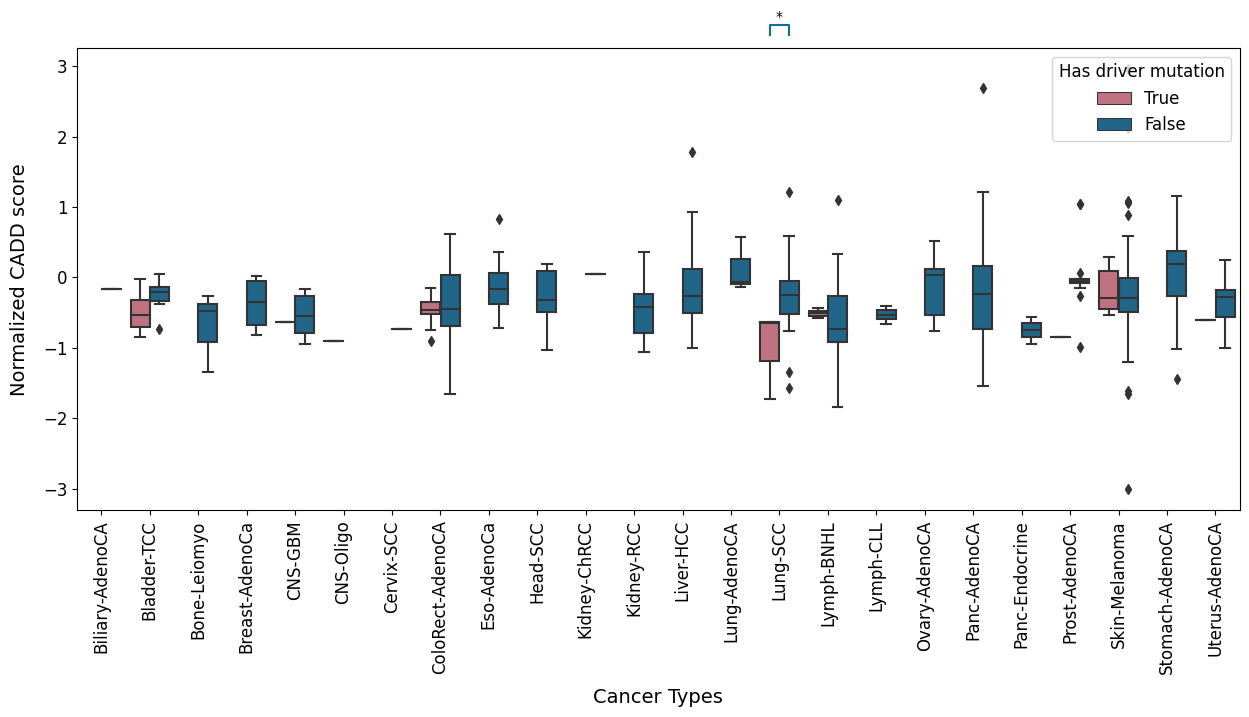

In [9]:
plt.figure(figsize=(15, 6))
colors = ["#CC6677", "#106C9A", "#529267"]
cmap = sns.color_palette(colors)
cancers = all_passenger_mut_promoter_scores["cancer_type"].unique().tolist()
cancers.sort()
ax = sns.boxplot(
    x="cancer_type", 
    y="CADD_score_normalized", 
    data=all_passenger_mut_promoter_scores,
    palette=cmap,
    order=cancers,
    hue="has_driver",
	hue_order=[True, False],
)
plt.xticks(fontsize=12, rotation=90)
plt.yticks(fontsize=12)
plt.xlabel("Cancer Types", fontsize=14, labelpad=10)
plt.ylabel("Normalized CADD score", fontsize=14, labelpad=10)
plt.legend(loc='upper right', title="Has driver mutation", fontsize=12, title_fontsize=12)

# add p-value annotation
box_pairs = []
cancer_types = all_passenger_mut_promoter_scores["cancer_type"].unique().tolist()
cancer_types = [x for x in CANCER_TYPES if x in cancer_types]
for cancer in cancer_types:
	cancer_data = all_passenger_mut_promoter_scores[all_passenger_mut_promoter_scores["cancer_type"] == cancer]
	if len(cancer_data["has_driver"].unique().tolist()) == 2:
		box_pairs.append(((cancer, True), (cancer, False)))
print(box_pairs)

annotator = Annotator(
    ax, 
    box_pairs, 
    data=all_passenger_mut_promoter_scores, 
    x="cancer_type", 
    y="CADD_score_normalized", 
    order=cancers,
    hue="has_driver",
	hue_order=[True, False],
)
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

False vs. True: Mann-Whitney-Wilcoxon test greater, P_val:1.530e-03 U_stat=9.489e+03


(<Axes: xlabel='Has driver mutation', ylabel='Normalized CADD score'>,
 [<statannotations.Annotation.Annotation at 0x104b91d60>])

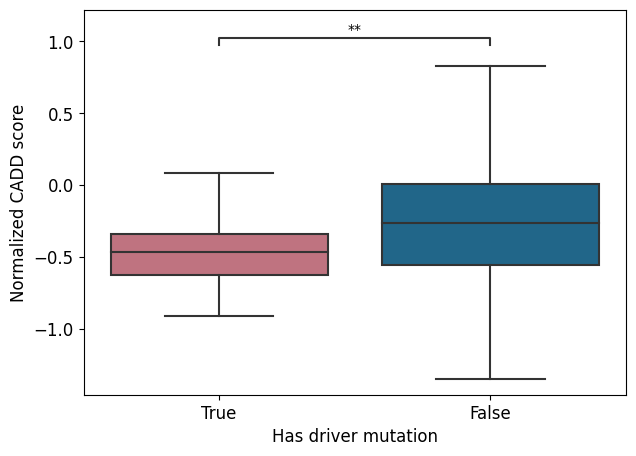

In [10]:
plt.figure(figsize=(7, 5))
ax = sns.boxplot(
    x="has_driver", 
    y="CADD_score_normalized", 
    data=all_passenger_mut_promoter_scores,
    palette=cmap,
    order=[True, False],
    showfliers=False
)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel("Has driver mutation", fontsize=12)
plt.ylabel("Normalized CADD score", fontsize=12)

# add p-value annotation
pairs = [(True, False)]
annotator = Annotator(
    ax, pairs, data=all_passenger_mut_promoter_scores, x="has_driver", y="CADD_score_normalized"
)
annotator.configure(test='Mann-Whitney-gt', text_format='star')
annotator.apply_and_annotate()

## Mutation density in promoters of samples with and without drivers

In [11]:
# get promoter passenger mutations
tumor_promoter_count = all_tumor_mut_promoter.dropna(subset=["promoter_gene"])
print(tumor_promoter_count.shape)
tumor_promoter_count = tumor_promoter_count[tumor_promoter_count["driver"] == False]
print(tumor_promoter_count.shape)
tumor_promoter_count = tumor_promoter_count.groupby(["Tumor_Sample_Barcode", "gene"]).agg({
    "has_driver": "first",
    "cancer_type": "first",
    "promoter_length": "first",
    "genome_wide_mutation_rate": "first",
    "cna_burden": "first",
    "promoter_gene": "count"
}).reset_index()
tumor_promoter_count.rename(columns={"promoter_gene": "num_promoters"}, inplace=True)
# adjust for genome wide mutation rate and promoter length
tumor_promoter_count["promoter_density_per_gb"] = tumor_promoter_count["num_promoters"] * 1e9 / (tumor_promoter_count["promoter_length"] * tumor_promoter_count["genome_wide_mutation_rate"] * tumor_promoter_count["cna_burden"])

print(tumor_promoter_count.shape)
tumor_promoter_count.head()

(453, 19)
(453, 19)
(381, 9)


,Tumor_Sample_Barcode,gene,has_driver,cancer_type,promoter_length,genome_wide_mutation_rate,cna_burden,num_promoters,promoter_density_per_gb
0,0009b464-b376-4fbc-8a56-da538269a02f,PTPRT,False,Ovary-AdenoCA,2501,16168,90.521483,2,0.546397
1,00aa769d-622c-433e-8a8a-63fb5c41ea42,PIK3CA,True,ColoRect-AdenoCA,2501,237798,9.697974,1,0.173379
2,00aa769d-622c-433e-8a8a-63fb5c41ea42,TERT,False,ColoRect-AdenoCA,2501,237798,9.697974,1,0.173379
3,04aa6b77-8074-480c-872e-a1a47afa5314,CYP2C8,False,Skin-Melanoma,2501,759325,86.898036,1,0.006060
4,04aa6b77-8074-480c-872e-a1a47afa5314,MECOM,False,Skin-Melanoma,2501,759325,86.898036,1,0.006060


In [12]:
# add rows for tumor samples without promoter mutations in the driver genes
print(tumor_promoter_count.shape)
tumor_promoter_all_count = tumor_promoter_count.copy()
for cancer_type in CANCER_TYPES:
	tumor_mut_cancer_df = tumor_mut_df[tumor_mut_df["cancer_type"] == cancer_type]
	all_tumors_cancer_list = tumor_mut_cancer_df["Tumor_Sample_Barcode"].unique().tolist()
	for tumor in all_tumors_cancer_list:
		driver_genes = pd.read_csv(f"{DRIVER_GENES}/{cancer_type}.tsv", sep="\t")
		driver_genes_list = driver_genes["gene"].unique().tolist()
		for gene in driver_genes_list:
			if len(tumor_promoter_all_count[(tumor_promoter_all_count["Tumor_Sample_Barcode"] == tumor) & (tumor_promoter_all_count["gene"] == gene)]) == 0:
				driver_status = tumor_mut_cancer_df[(tumor_mut_cancer_df["Tumor_Sample_Barcode"] == tumor) \
									& (tumor_mut_cancer_df["gene"] == gene)]["has_driver"].values
				driver_status = driver_status[0] if len(driver_status) > 0 else False
				genome_wide_mut_rate = tumor_mut_cancer_df[tumor_mut_cancer_df["Tumor_Sample_Barcode"] == tumor]["genome_wide_mutation_rate"].values[0] \
										if tumor in tumor_mut_cancer_df["Tumor_Sample_Barcode"].unique() else 1
				tumor_gene_row = pd.DataFrame({
					"Tumor_Sample_Barcode": [tumor],
					"gene": [gene],
					"cancer_type": [cancer_type],
					"has_driver": [driver_status],
					"num_promoters": [0],
					"promoter_density_per_gb": [0],
					"promoter_length": driver_genes[driver_genes["gene"] == gene]["promoter_length"].values[0],
					"genome_wide_mutation_rate": genome_wide_mut_rate
				})
				tumor_promoter_all_count = pd.concat([tumor_promoter_all_count, tumor_gene_row], axis=0)
print(tumor_promoter_all_count.shape)
tumor_promoter_all_count["has_promoter"] = tumor_promoter_all_count["num_promoters"] > 0
tumor_promoter_all_count.to_csv(f"{MUTATION_DENSITY_GENIC_REGIONS}/all_promoters.tsv", sep="\t", index=False)
tumor_promoter_all_count.head()

(381, 9)
(28271, 9)


,Tumor_Sample_Barcode,gene,has_driver,cancer_type,promoter_length,genome_wide_mutation_rate,cna_burden,num_promoters,promoter_density_per_gb,has_promoter
0,0009b464-b376-4fbc-8a56-da538269a02f,PTPRT,False,Ovary-AdenoCA,2501,16168,90.521483,2,0.546397,True
1,00aa769d-622c-433e-8a8a-63fb5c41ea42,PIK3CA,True,ColoRect-AdenoCA,2501,237798,9.697974,1,0.173379,True
2,00aa769d-622c-433e-8a8a-63fb5c41ea42,TERT,False,ColoRect-AdenoCA,2501,237798,9.697974,1,0.173379,True
3,04aa6b77-8074-480c-872e-a1a47afa5314,CYP2C8,False,Skin-Melanoma,2501,759325,86.898036,1,0.006060,True
4,04aa6b77-8074-480c-872e-a1a47afa5314,MECOM,False,Skin-Melanoma,2501,759325,86.898036,1,0.006060,True


In [13]:
# Average passenger mutation density in samples without driver mutations as a fraction of average passenger mutation density in all samples
for cancer_type in CANCER_TYPES:
	tumor_mut_density_grouped = tumor_promoter_all_count[tumor_promoter_all_count["cancer_type"] == cancer_type]
	print(cancer_type, tumor_mut_density_grouped.shape)
	tumor_mut_density_grouped = tumor_mut_density_grouped.groupby(["has_driver"]).agg({
		"promoter_density_per_gb": "mean",
	}).reset_index()
	tumor_mut_density_grouped["genic_region"] = "promoter"
	tumor_mut_density_grouped = tumor_mut_density_grouped.pivot(index="genic_region", columns="has_driver", values="promoter_density_per_gb").fillna(0)
	# add column for True if no driver mutations
	if False not in tumor_mut_density_grouped.columns:
		tumor_mut_density_grouped[False] = 0
	if True not in tumor_mut_density_grouped.columns:
		tumor_mut_density_grouped[True] = 0
	tumor_mut_density_grouped["fraction"] = tumor_mut_density_grouped[False] / (tumor_mut_density_grouped[False] + tumor_mut_density_grouped[True])
	tumor_mut_density_grouped.to_csv(f"{MUTATION_DENSITY_FRACTION_RESULTS}/{cancer_type}_promoter.tsv", sep="\t")

CNS-Oligo (90, 10)
Kidney-ChRCC (80, 10)
Prost-AdenoCA (3601, 10)
Kidney-RCC (1728, 10)
Stomach-AdenoCA (966, 10)
CNS-Medullo (1066, 10)
Thy-AdenoCA (80, 10)
Myeloid-MPN (76, 10)
Bone-Leiomyo (168, 10)
Lymph-BNHL (1560, 10)
Myeloid-AML (45, 10)
Lung-AdenoCA (360, 10)
CNS-GBM (440, 10)
Head-SCC (627, 10)
Breast-AdenoCa (2167, 10)
Ovary-AdenoCA (1008, 10)
CNS-PiloAstro (273, 10)
Cervix-SCC (36, 10)
Liver-HCC (4251, 10)
Bone-Osteosarc (132, 10)
Biliary-AdenoCA (384, 10)
Skin-Melanoma (1391, 10)
Lung-SCC (528, 10)
Lymph-CLL (1022, 10)
Panc-Endocrine (704, 10)
Bladder-TCC (414, 10)
Panc-AdenoCA (2640, 10)
ColoRect-AdenoCA (660, 10)
Breast-LobularCa (44, 10)
Eso-AdenoCa (1067, 10)
Uterus-AdenoCA (663, 10)


In [14]:
tumor_promoter_count_with_driver = tumor_promoter_all_count[tumor_promoter_all_count["has_driver"]]
print("True:", tumor_promoter_count_with_driver.shape)
tumor_promoter_count_without_driver = tumor_promoter_all_count[~tumor_promoter_all_count["has_driver"]]
print("False:", tumor_promoter_count_without_driver.shape)

tumor_has_promoter = tumor_promoter_all_count[tumor_promoter_all_count["promoter_density_per_gb"] > 0]

print(tumor_has_promoter.shape)
print(tumor_has_promoter["has_driver"].value_counts())

# mann-whitney test
stat, p = ttest_ind(
    tumor_promoter_count_with_driver["promoter_density_per_gb"], 
    tumor_promoter_count_without_driver["promoter_density_per_gb"],
    alternative="less")
print(f"p-value: {p}, stat: {stat}")

stat, p = mannwhitneyu(
    tumor_promoter_count_with_driver["promoter_density_per_gb"], 
	tumor_promoter_count_without_driver["promoter_density_per_gb"],
	alternative="less"
)
print(f"p-value: {p}, stat: {stat}")

True: (3094, 10)
False: (25177, 10)
(381, 10)
False    347
True      34
Name: has_driver, dtype: int64
p-value: 0.2432737341814365, stat: -0.6958197035830956
p-value: 0.09988965627319035, stat: 38839115.5


p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04



(<Axes: xlabel='Has Driver', ylabel='Promoter Density per Gb'>,
 [<statannotations.Annotation.Annotation at 0x32f8d86a0>])

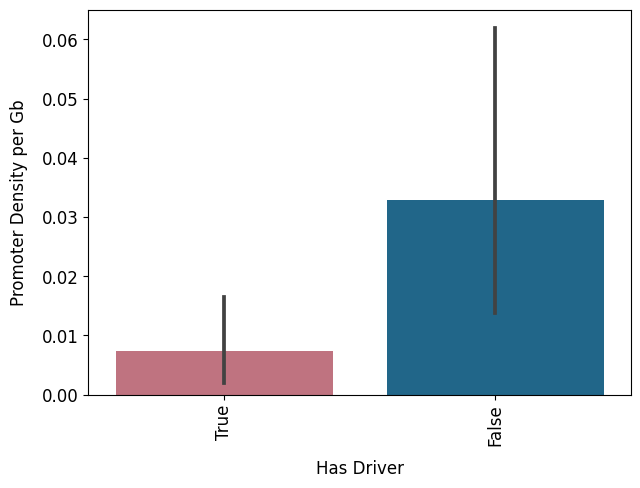

In [15]:
plt.figure(figsize=(7, 5))
ax = sns.barplot(
    x="has_driver",
    y="promoter_density_per_gb",
    data=tumor_promoter_all_count, 
    order=[True, False],
    palette=cmap,
)
plt.xlabel("Has Driver", fontsize=12, labelpad=10)
plt.xticks(fontsize=12, rotation=90)
plt.ylabel("Promoter Density per Gb", fontsize=12, labelpad=10)
plt.yticks(fontsize=12)

# add p-value annotation
annotator = Annotator(
    ax,
    x="has_driver", 
    y="promoter_density_per_gb",
    data=tumor_promoter_all_count, 
    pairs=[(True, False)],
    order=[True, False],
)
# don't show non-significant p-values
annotator.configure(test='Mann-Whitney-gt', text_format='star', loc='outside', hide_non_significant=True, color=colors[0])
annotator.apply_and_annotate()
annotator.configure(test='Mann-Whitney-ls', text_format='star', loc='outside', hide_non_significant=True, color=colors[1])
annotator.apply_and_annotate()

## Association between having a driver mutation and having a promoter mutation in a sample

In [16]:
# chi-square test

# all samples
print("All samples")
crosstab = pd.crosstab(
    tumor_promoter_all_count["has_driver"], 
    tumor_promoter_all_count["has_promoter"]
)
print(crosstab)
stat, p, dof, expected = chi2_contingency(crosstab)
print(f"p-value: {p}, stat: {stat}, expected: {expected}")

All samples
has_promoter  False  True 
has_driver                
False         24830    347
True           3060     34
p-value: 0.23440897766570973, stat: 1.413906471963269, expected: [[24837.69693325   339.30306675]
 [ 3052.30306675    41.69693325]]
